In [1]:
from brickschema import Graph
import matplotlib.pyplot as plt
import pandas as pd
import rdflib

import dbmanager

2024-10-08:13:06:38,940 WARNING [__init__.py:22] sqlalchemy not installed. SQL-backed graph support will not be available. Try 'pip install brickschema[persistence]' to install it.


No module named 'pkg_resources'


In [2]:
building_ttl_file = '../../datasets/bts_site_b_train/Site_B_cleaned.ttl'
data_zip_file = '../../datasets/bts_site_b_train/train.zip'
mapping_csv_file = '../../datasets/bts_site_b_train/mapper_TrainOnly.csv'

In [3]:
g = Graph(load_brick=True) # should actually loading the v1.2.1 brick schema
g.load_file(building_ttl_file)
print(f'Building model has {len(g)} triples')

Building model has 52457 triples


In [4]:
g.expand(profile='rdfs') # inference using RDFS reasoning
print(f'Expanded building model has {len(g)} triples')

Expanded building model has 89052 triples


In [5]:
g.expand(profile='shacl') # infererence using Brick classes from Brick tags
print(f'Expanded building model has {len(g)} triples')

2024-10-08:13:07:17,691 WARNING [graph.py:293] Validation Report
Conforms: False
Results (52):
Constraint Violation in ClassConstraintComponent (http://www.w3.org/ns/shacl#ClassConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ rdf:type rdfs:Resource ; sh:class brick:Location ; sh:message Literal("A Location's parts should be always Locations.") ; sh:path brick:hasPart ]
	Focus Node: p33f3e0c2_f2cd_471c_b5a0_4655c2bd4623:5c2c591b_b04c_47d6_a586_7b323df99c9a
	Value Node: p33f3e0c2_f2cd_471c_b5a0_4655c2bd4623:d02c6fdd_ce6b_44a1_b193_1ede85e7d4c8.6d18ee1e_22f5_495f_89e6_cd613015478e
	Result Path: brick:hasPart
	Message: A Location's parts should be always Locations.
Constraint Violation in ClassConstraintComponent (http://www.w3.org/ns/shacl#ClassConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ rdf:type rdfs:Resource ; sh:class brick:Location ; sh:message Literal("A Location's parts should be always Locations.") ; sh:path brick:hasPart ]
	Focus Node: p33f3e0c2_f2

Expanded graph has 94491 triples


In [6]:
db = dbmanager.DBManager(data_zip_file, mapping_csv_file)
print(f'Dataset contains {len(db)} time series')

Dataset contains 668 time series


In [19]:
def get_rooms_with_temp():
    rooms_with_temp_query = '''
        SELECT DISTINCT ?class ?loc ?ats ?atsp WHERE  {
            ?ats    a                 brick:Air_Temperature_Sensor .
            ?atsp   a                 brick:Room_Air_Temperature_Setpoint .
            ?ats    brick:isPointOf   ?loc .
            ?atsp   brick:isPointOf   ?loc .
            ?loc    a                 brick:Room .
            ?loc    a                 ?class   .
            ?class  rdfs:subClassOf   brick:Room .
        }
        ORDER BY ?class ?loc
    '''

    return g.query(rooms_with_temp_query)

In [20]:
rooms_with_temp = get_rooms_with_temp()
for row in rooms_with_temp:
    print(row)

(rdflib.term.URIRef('https://brickschema.org/schema/Brick#Conference_Room'), rdflib.term.URIRef('dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/site/c495fbd8_7a71_44b4_ad2a_014ac2df7ce9/building/95d1f7f3_33c6_4bd8_a82c_99c550d83bb8#3b373634_2461_4b61_8bcb_068c12b7e1a8.6af9698e_b72b_48d7_b864_9a0d518ec3b1'), rdflib.term.URIRef('dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/site/c495fbd8_7a71_44b4_ad2a_014ac2df7ce9/building/95d1f7f3_33c6_4bd8_a82c_99c550d83bb8#554f7ba1_7232_4a12_a2b6_0954976ff3b9.8869a237_11bc_44a4_b0c3_4c1689effddd'), rdflib.term.URIRef('dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/site/c495fbd8_7a71_44b4_ad2a_014ac2df7ce9/building/95d1f7f3_33c6_4bd8_a82c_99c550d83bb8#554f7ba1_7232_4a12_a2b6_0954976ff3b9.a0812711_4b5c_45db_8f28_4addba2e1f0a'))
(rdflib.term.URIRef('https://brickschema.org/schema/Brick#Conference_Room'), rdflib.term.URIRef('dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/site/c495fbd8_7a71_44b4_ad2a_014ac2df7ce9/building/95d1f7f3_33c6_4bd8_a82c_99c550d83bb8#3b3

In [46]:
def get_room_temp_stream_ids(room_uri):
    room_temp_query = '''
        SELECT ?ats_sid ?atsp_sid WHERE  {
            ?ats  a                 brick:Air_Temperature_Sensor .
            ?ats  brick:isPointOf   ?room_uri .
            ?ats  senaps:stream_id  ?ats_sid .
            ?atsp a                 brick:Room_Air_Temperature_Setpoint .
            ?atsp brick:isPointOf   ?room_uri .
            ?atsp senaps:stream_id  ?atsp_sid .
        }
    '''

    results = g.query(room_temp_query, initBindings={'room_uri': room_uri})
    return results.bindings[0]

In [53]:
def get_outside_temp_stream_id():
    outside_temp_query = '''
        SELECT ?ats_sid WHERE  {
            ?ats  a                 brick:Outside_Air_Temperature_Sensor .
            ?ats  brick:isPointOf   ?loc .
            ?loc   a                brick:Weather_Station .
            ?ats  senaps:stream_id  ?ats_sid .
        }
    '''

    results = g.query(outside_temp_query)
    return results.bindings[0]

In [54]:
room_temp_stream_ids = get_room_temp_stream_ids(rdflib.term.URIRef('dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/site/c495fbd8_7a71_44b4_ad2a_014ac2df7ce9/building/95d1f7f3_33c6_4bd8_a82c_99c550d83bb8#3b373634_2461_4b61_8bcb_068c12b7e1a8.6af9698e_b72b_48d7_b864_9a0d518ec3b1'))
outside_temp_stream_id = get_outside_temp_stream_id()




In [55]:
print(room_temp_stream_ids)
print(outside_temp_stream_id)

{rdflib.term.Variable('ats_sid'): rdflib.term.Literal('9e5771cc_d778_41a4_9bd3_73da4e9852d2'), rdflib.term.Variable('atsp_sid'): rdflib.term.Literal('63aeb858_0500_4bda_a9fc_b7eaef4a4f8d')}
{rdflib.term.Variable('ats_sid'): rdflib.term.Literal('664ddc27_ccc5_43a1_97b7_3000c0e948db')}


In [56]:
def get_daily_median(df):
    df['time'] = pd.to_datetime(df['time'])
    df['date'] = df['time'].dt.date
    df = df.groupby(['date', 'label'])['value'].median().unstack()
    return df

In [58]:
outside_air_temp_df = db.get_stream(outside_temp_stream_id['ats_sid'])
outside_median_df = get_daily_median(outside_air_temp_df)
outside_median_df.head()

label,Outside_Air_Temperature_Sensor
date,
2021-01-01,24.940
2021-01-02,18.630
2021-01-03,17.620
2021-01-04,16.035
2021-01-05,16.505


In [59]:
inside_air_temp_df = db.get_stream(room_temp_stream_ids['ats_sid'])
inside_median_df = get_daily_median(inside_air_temp_df)
inside_median_df.head()

label,Air_Temperature_Sensor
date,
2021-01-01,24.60
2021-01-02,24.60
2021-01-03,23.72
2021-01-04,21.60
2021-01-05,21.84


In [60]:
room_air_temp_setpoint_df = db.get_stream(room_temp_stream_ids['atsp_sid'])
setpoint_median_df = get_daily_median(room_air_temp_setpoint_df)
setpoint_median_df.head()

label,Room_Air_Temperature_Setpoint
date,
2021-01-01,22.0
2021-01-02,22.0
2021-01-03,22.0
2021-01-04,22.0
2021-01-05,22.0


In [67]:
def get_room_class(room_uri):
    room_type_query = '''
        SELECT ?class WHERE {
            ?room_uri  a                ?class .
            ?class     rdfs:subClassOf  brick:Room .
        }
    '''

    results = g.query(room_type_query, initBindings={'room_uri': room_uri})
    return results.bindings[0]['class'].replace('https://brickschema.org/schema/Brick#', '')

In [68]:
room_class = get_room_class(rdflib.term.URIRef('dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/site/c495fbd8_7a71_44b4_ad2a_014ac2df7ce9/building/95d1f7f3_33c6_4bd8_a82c_99c550d83bb8#3b373634_2461_4b61_8bcb_068c12b7e1a8.6af9698e_b72b_48d7_b864_9a0d518ec3b1'))
print(room_class)

Conference_Room


In [85]:
def plot_daily_room_temp(room_uri):
    outside_temp_stream_id = get_outside_temp_stream_id()
    room_temp_stream_ids = get_room_temp_stream_ids(room_uri)

    outside_air_temp_df = db.get_stream(outside_temp_stream_id['ats_sid'])
    inside_air_temp_df = db.get_stream(room_temp_stream_ids['ats_sid'])
    room_air_temp_setpoint_df = db.get_stream(room_temp_stream_ids['atsp_sid'])

    outside_median_df = get_daily_median(outside_air_temp_df)
    inside_median_df = get_daily_median(inside_air_temp_df)
    setpoint_median_df = get_daily_median(room_air_temp_setpoint_df)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(inside_median_df.index, inside_median_df[inside_median_df.columns[0]], label=inside_median_df.columns[0], marker=',')
    ax.plot(outside_median_df.index, outside_median_df[outside_median_df.columns[0]], label=outside_median_df.columns[0], color='g', marker=',', alpha=0.5)
    ax.plot(setpoint_median_df.index, setpoint_median_df[setpoint_median_df.columns[0]], label=setpoint_median_df.columns[0], color='r', marker=',', alpha=0.5)

    title = get_room_class(room_uri).replace('_', ' ') + ' Daily Median Temperature'
    subtitle = f'{room_uri}'
    subtitle = 'URI: ' + subtitle[subtitle.find('#')+1:]

    # plt.suptitle(title, y=1.05, fontsize=18)
    plt.suptitle(title, fontsize=12, y=0.97)
    plt.title(subtitle, fontsize=8)
    plt.xlabel('Date')
    plt.ylabel('Daily Median Temperature')
    plt.legend()
    plt.grid(True)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

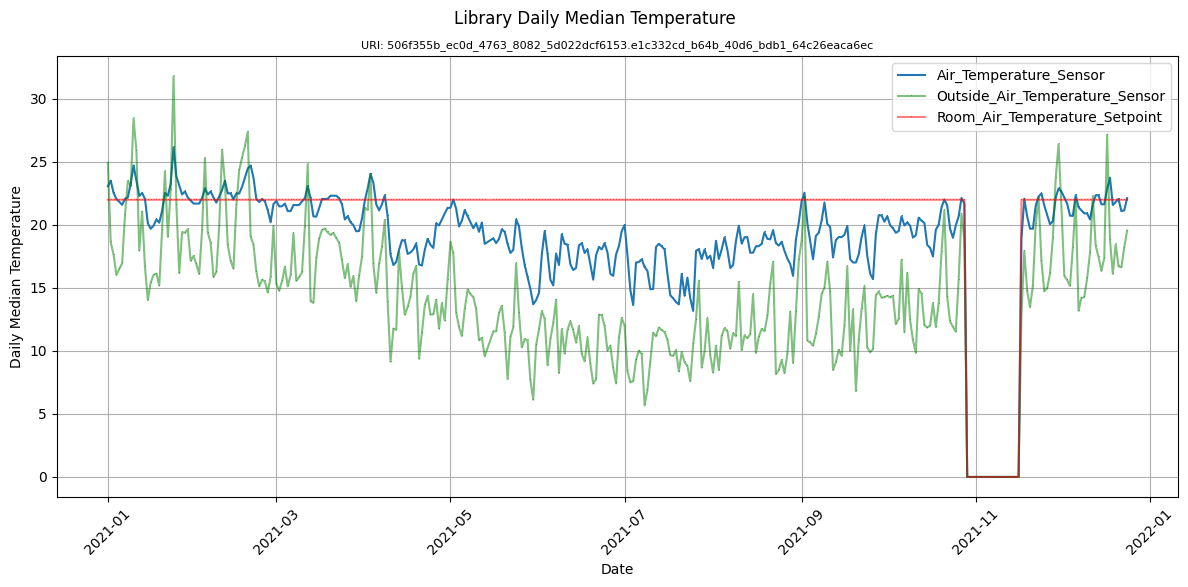

In [87]:
plot_daily_room_temp(rdflib.term.URIRef('dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/site/c495fbd8_7a71_44b4_ad2a_014ac2df7ce9/building/95d1f7f3_33c6_4bd8_a82c_99c550d83bb8#506f355b_ec0d_4763_8082_5d022dcf6153.e1c332cd_b64b_40d6_bdb1_64c26eaca6ec'))
